In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.tsa.stattools import grangercausalitytests
from hurst import compute_Hc
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch

In [ ]:
class TradingAnalysis:
    def __init__(self, data_file):
        self.data = pd.read_csv(data_file, index_col=0)

    def plot_price_series(self):
        """
        Plot the price series for each asset.
        """
        plt.figure(figsize=(12, 6))
        for col in self.data.columns:
            plt.plot(self.data[col], label=col)
        plt.title("Price Series")
        plt.xlabel("Time")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    def plot_distributions(self):
        """
        Plot the distribution of prices for each asset using histograms and density plots.
        """
        for col in self.data.columns:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
            sns.histplot(self.data[col], kde=True, ax=ax1)
            ax1.set_title(f"Distribution of {col} Prices")
            ax1.set_xlabel("Price")
            ax1.set_ylabel("Frequency")
            
            sns.kdeplot(self.data[col], ax=ax2)
            ax2.set_title(f"Density Plot of {col} Prices")
            ax2.set_xlabel("Price")
            ax2.set_ylabel("Density")
            
            plt.tight_layout()
            plt.show()

    def plot_correlation_matrix(self):
        """
        Plot the correlation matrix heatmap for the asset prices.
        """
        corr_matrix = self.data.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title("Correlation Matrix")
        plt.show()

    def augmented_dickey_fuller_test(self):
        """
        Perform the Augmented Dickey-Fuller test for stationarity on each asset's price series.
        The test checks if the series is stationary or if it has a unit root (non-stationary).
        """
        print("Augmented Dickey-Fuller Tests:")
        for col in self.data.columns:
            adf_result = adfuller(self.data[col])
            print(f"{col}: ADF Statistic = {adf_result[0]}, p-value = {adf_result[1] }")
            if adf_result[1] < 0.05:
                print(f"The price series of {col} is likely stationary.")
            else:
                print(f"The price series of {col} is likely non-stationary.")
            print()

    def hurst_exponent(self):
        """
        Calculate the Hurst Exponent for each asset's price series using the hurst library.
        The Hurst Exponent measures the degree of long-term memory or persistence in a time series.
        A value between 0 and 0.5 indicates mean reversion, while a value between 0.5 and 1 indicates trend persistence.
        """
        print("Hurst Exponents:")
        for col in self.data.columns:
            X = self.data[col].values
            H, _, _ = compute_Hc(X)
            print(f"{col}: Hurst Exponent = {H}")
            if H < 0.5:
                print(f"The price series of {col} exhibits mean reversion.")
            elif H > 0.5:
                print(f"The price series of {col} exhibits trend persistence.")
            else:
                print(f"The price series of {col} is similar to a random walk.")
            print()

    def cointegration_test(self):
        """
        Perform cointegration tests between pairs of asset price series.
        Cointegration suggests a long-term equilibrium relationship between two non-stationary series.
        """
        print("Cointegration Tests:")
        for i in range(len(self.data.columns)):
            for j in range(i+1, len(self.data.columns)):
                coint_result = coint(self.data.iloc[:,i], self.data.iloc[:,j])
                print(f"Pair: {self.data.columns[i]} and {self.data.columns[j]}")
                print(coint_result)
                if coint_result[1] < 0.05:
                    print(f"{self.data.columns[i]} and {self.data.columns[j]} are likely cointegrated (p-value = {coint_result[1]}).")
                else:
                    print(f"{self.data.columns[i]} and {self.data.columns[j]} are likely not cointegrated (p-value = {coint_result[1]}).")
                print()

    def granger_causality_test(self):
        """
        Perform Granger Causality tests between pairs of asset price series.
        Granger Causality tests if one time series is useful in predicting another.
        """
        print("Granger Causality Tests:")
        for col1 in self.data.columns:
            for col2 in self.data.columns:
                if col1 != col2:
                    gc_result = grangercausalitytests(self.data[[col1, col2]], maxlag=5, verbose=False)
                    p_values = [gc_result[i+1][0]['ssr_ftest'][1] for i in range(5)]
                    min_p_value = min(p_values)
                    if min_p_value < 0.05:
                        print(f"{col2} Granger-causes {col1} (minimum p-value = {min_p_value} across 5 lags).")
                    else:
                        print(f"No significant Granger Causality found from {col2} to {col1} (minimum p-value = {min_p_value} across 5 lags).")
                    print()

    def predictive_modeling(self):
        """
        Perform predictive modeling on the asset returns using various classification algorithms.
        Visualize the prediction results using confusion matrices and evaluate the performance.
        """
        returns = self.data.pct_change().dropna()

        for col in returns.columns:
            print(f"\nPredictive Modeling for {col}:")
            X = returns.drop(columns=[col]).values[:-1]
            y = np.where(returns[col].values[1:] > 0, 1, 0)

            models = [
                LogisticRegression(),
                LinearDiscriminantAnalysis(),
                QuadraticDiscriminantAnalysis(),
                SVC(kernel='linear'),
                SVC(kernel='rbf'),
                DecisionTreeClassifier(),
                RandomForestClassifier(),
            ]

            for model in models:
                model.fit(X, y)
                y_pred = model.predict(X)
                print(f"\n{type(model).__name__} Results:")
                print(classification_report(y, y_pred))

                accuracy = accuracy_score(y, y_pred)
                precision = precision_score(y, y_pred)
                recall = recall_score(y, y_pred)
                f1 = f1_score(y, y_pred)

                print(f"Accuracy: {accuracy}")
                print(f"Precision: {precision}")
                print(f"Recall: {recall}")
                print(f"F1-score: {f1}")

                print("\nAnalysis:")
                print("- Accuracy measures the overall correctness of predictions.")
                print("- Precision indicates the proportion of true positive predictions among the positive predictions.")
                print("- Recall measures the proportion of actual positive instances that were correctly predicted.")
                print("- F1-score is the harmonic mean of precision and recall, providing a balanced evaluation.")

                cm = confusion_matrix(y, y_pred)
                plt.figure(figsize=(6, 4))
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
                plt.title(f"{type(model).__name__} Confusion Matrix for {col}")
                plt.xlabel("Predicted")
                plt.ylabel("Actual")
                plt.show()

    def principal_component_analysis(self):
        """
        Perform Principal Component Analysis (PCA) on the asset returns.
        Visualize the explained variance ratios and principal component loadings.
        """
        returns = self.data.pct_change().dropna()

        pca = PCA()
        pca.fit(returns)

        plt.figure(figsize=(8, 4))
        plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
        plt.xlabel("Principal Component")
        plt.ylabel("Explained Variance Ratio")
        plt.title("Scree Plot")
        plt.show()

        loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i+1}" for i in range(len(self.data.columns))], index=self.data.columns)
        plt.figure(figsize=(8, 6))
        sns.heatmap(loadings, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title("Principal Component Loadings")
        plt.show()
    
    

In [ ]:
data = pd.read_csv("/Users/divy/Desktop/Chicago-Trading-Competition-2024/case_1/Case1_Historical.csv", index_col=0)

for i in range(len(data.columns)):
    print(data.iloc[:,i].describe())

In [ ]:

def cointegration_test(new_data):
        """
        Perform cointegration tests between pairs of asset price series.
        Cointegration suggests a long-term equilibrium relationship between two non-stationary series.
        """
        print("Cointegration Tests:")
        glob = 0
        for n in range(10000):
            data = new_data.sample(frac=1)
            coint_num = 0
            for i in range(len(data.columns)):
                for j in range(i+1, len(data.columns)):
                    coint_result = coint(data.iloc[:,i], data.iloc[:,j])
                    # print(f"Pair: {data.columns[i]} and {data.columns[j]}")
                    # print(coint_result)
                    if coint_result[1] < 0.05:
                        coint_num += 1
                        # print(f"{data.columns[i]} and {data.columns[j]} are likely cointegrated (p-value = {coint_result[1]}).")
                    else:
                        pass
                        # print(f"{data.columns[i]} and {data.columns[j]} are likely not cointegrated (p-value = {coint_result[1]}).")
                    print()
            glob += coint_num
            #print(f"Number of cointegrated pairs: {coint_num}")
            #print("\n\n")
        print(f"Average number of cointegrated pairs: {glob/10000}")

cointegration_test(data)


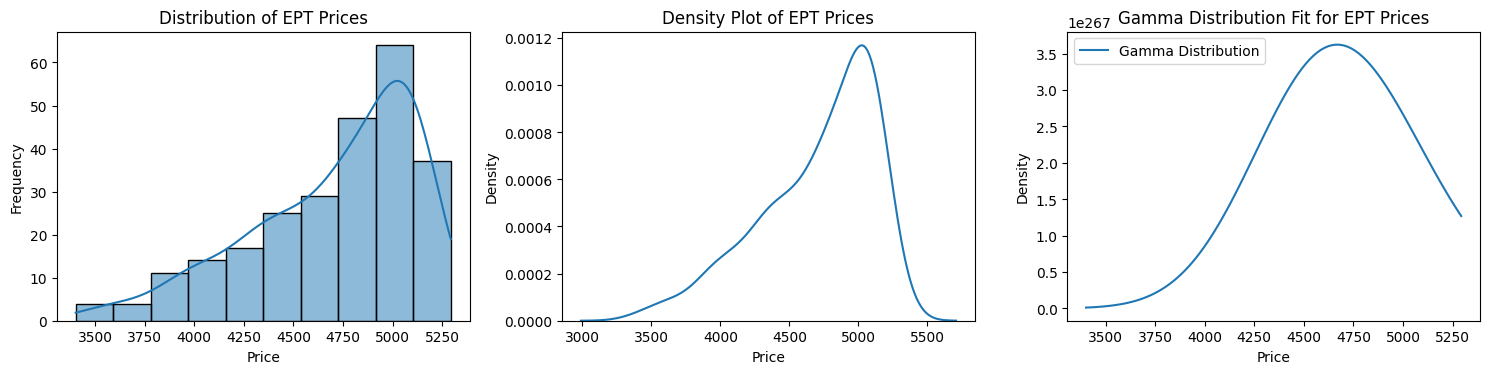

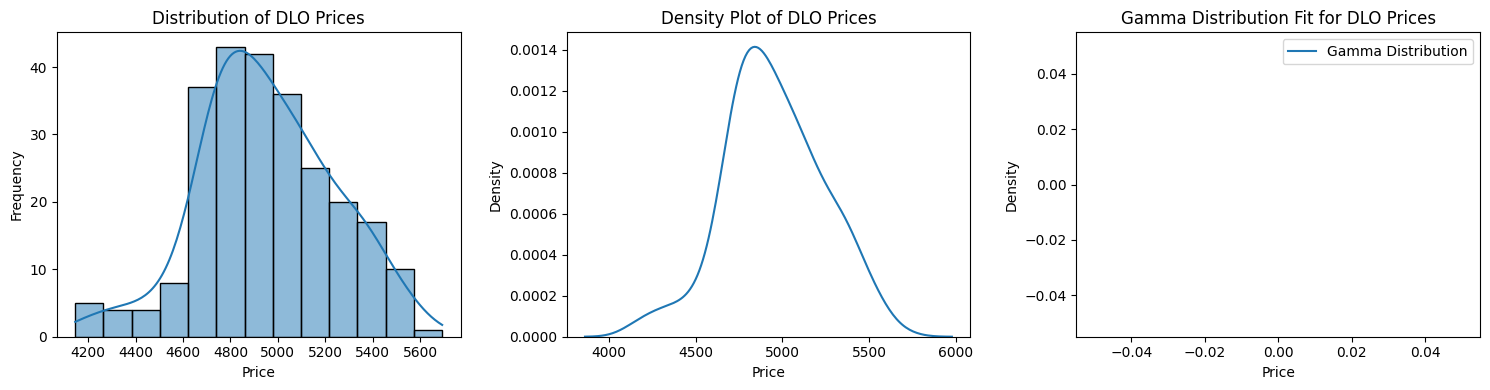

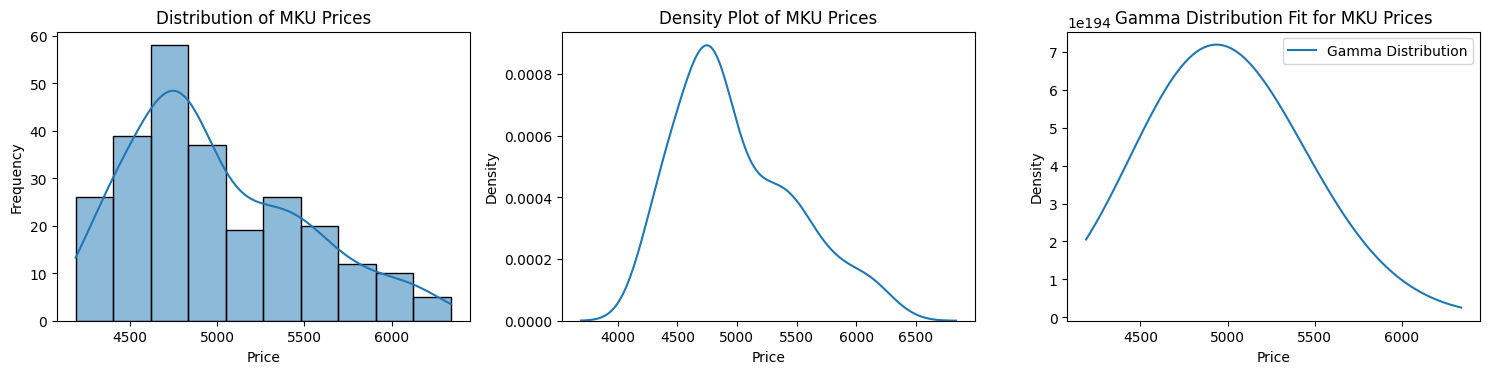

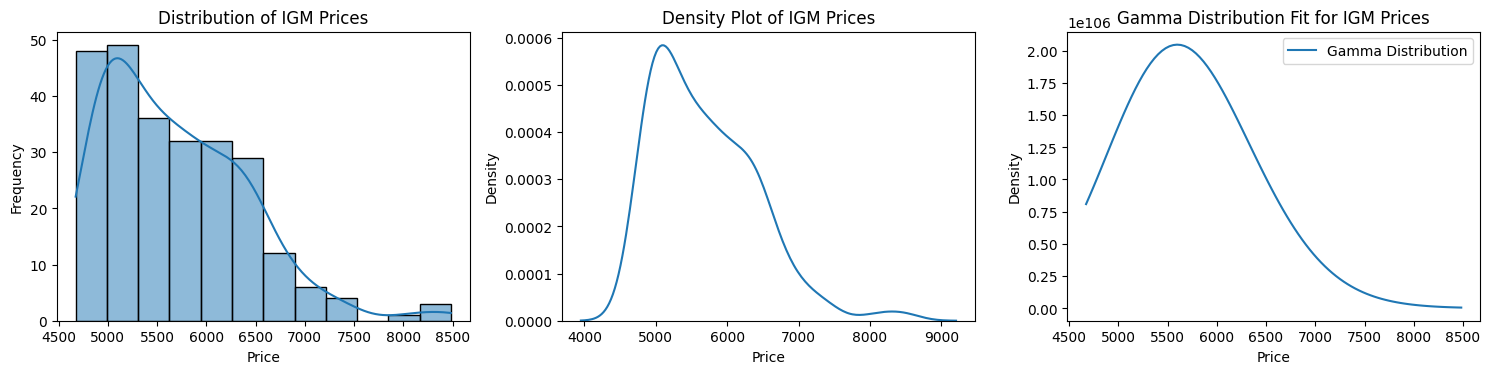

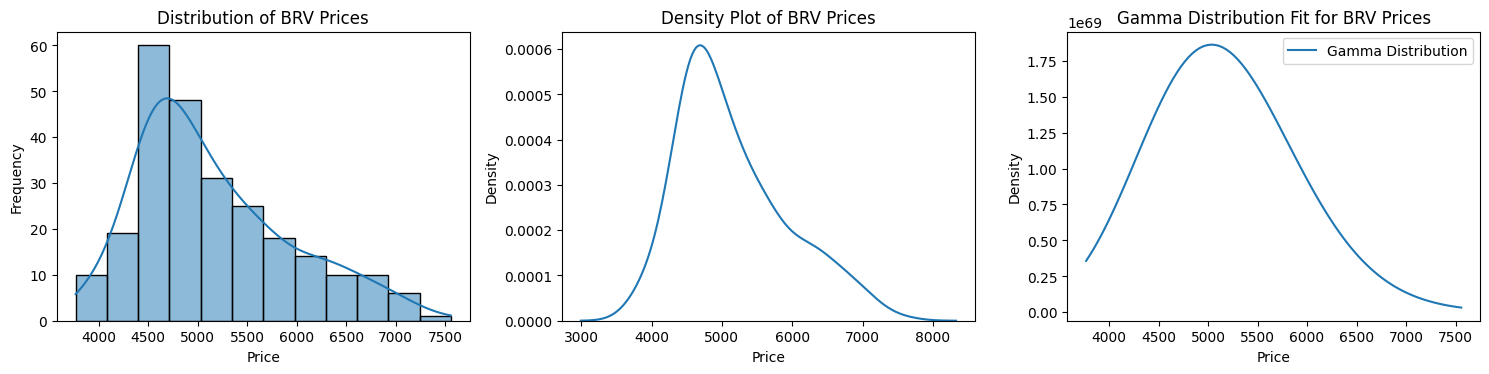

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from prediction import HistPred, GammaKDE, GammaDistribution, GaussianKDE
import numpy as np

# Load the data
data = pd.read_csv("/Users/divy/Desktop/Chicago-Trading-Competition-2024/case_1/Case1_Historical.csv", index_col=0)

# Iterate over columns and plot
for col in data.columns:
    col_data = HistPred(col, data[col])
    
    # Fit the Gamma distribution
    # kde = GaussianKDE(data[col])
    # kde.fit()
    # gamma_dist = GammaDistribution(data[col], kde)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # Histogram with KDE
    sns.histplot(data[col], kde=True, ax=ax1)
    ax1.set_title(f"Distribution of {col} Prices")
    ax1.set_xlabel("Price")
    ax1.set_ylabel("Frequency")
    
    # Density plot
    sns.kdeplot(data[col], ax=ax2)
    ax2.set_title(f"Density Plot of {col} Prices")
    ax2.set_xlabel("Price")
    ax2.set_ylabel("Density")
    
    
    # Plot the fitted Gamma distribution
    # x = np.linspace(data[col].min(), data[col].max(), 100)
    # y = gamma_dist.pdf(x)
    # ax3.plot(x, y, 'r-', lw=2, label='Gamma PDF')
    # ax3.set_title(f"Fitted Gamma Distribution of {col} Prices")
    # ax3.set_xlabel("Price")
    # ax3.set_ylabel("Density")
    # ax3.legend(loc='best')
    
    # plt.tight_layout()
    # plt.show()

    # Gamma distribution fit
    gamma_kde = GammaKDE(data[col])
    gamma_kde.fit()
    x_range = np.linspace(data[col].min(), data[col].max(), 100)
    gamma_pdf = [gamma_kde.pdf(x) for x in x_range]
    ax3.plot(x_range, gamma_pdf, label='Gamma Distribution')
    ax3.set_title(f"Gamma Distribution Fit for {col} Prices")
    ax3.set_xlabel("Price")
    ax3.set_ylabel("Density")
    ax3.legend()

    plt.tight_layout()
    plt.show()

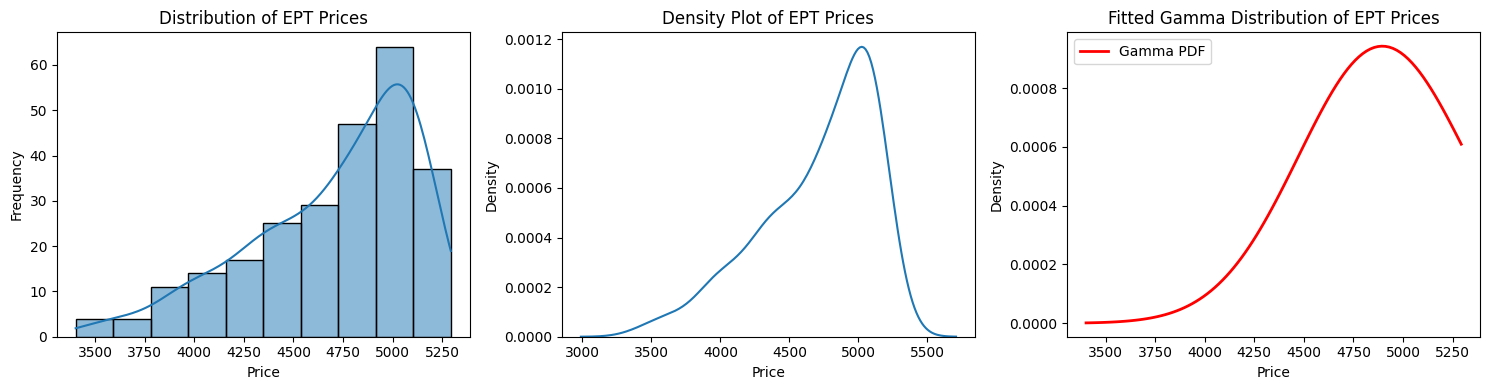

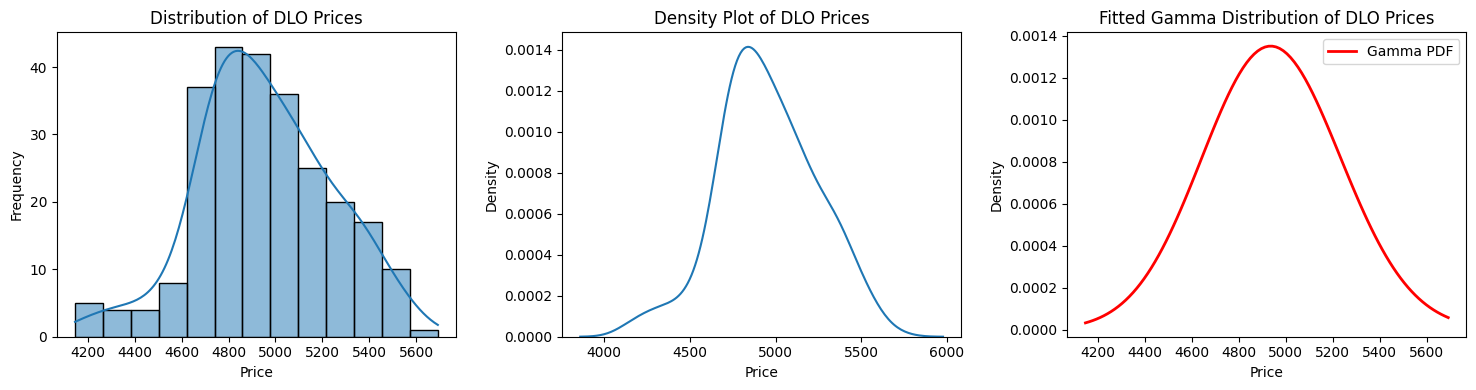

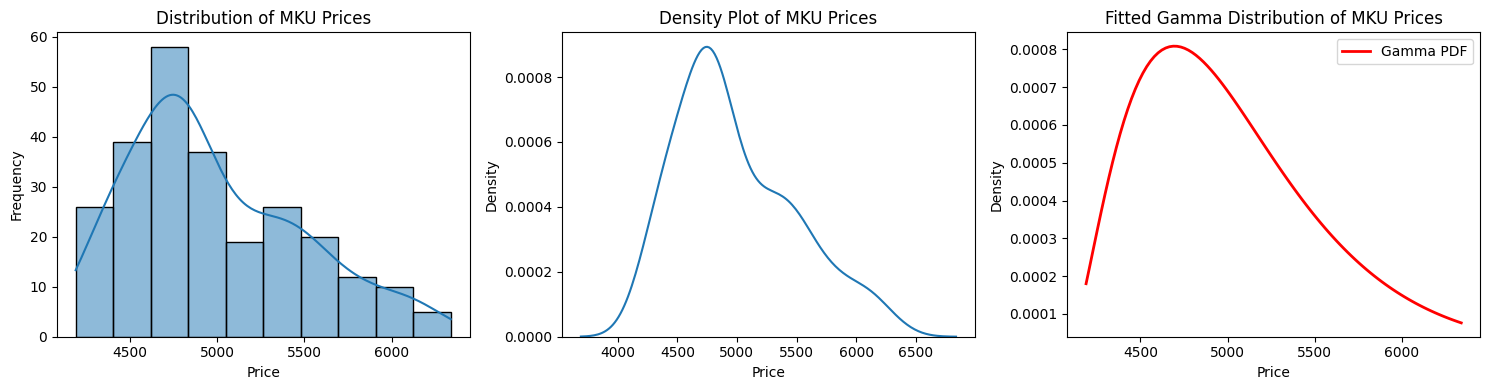

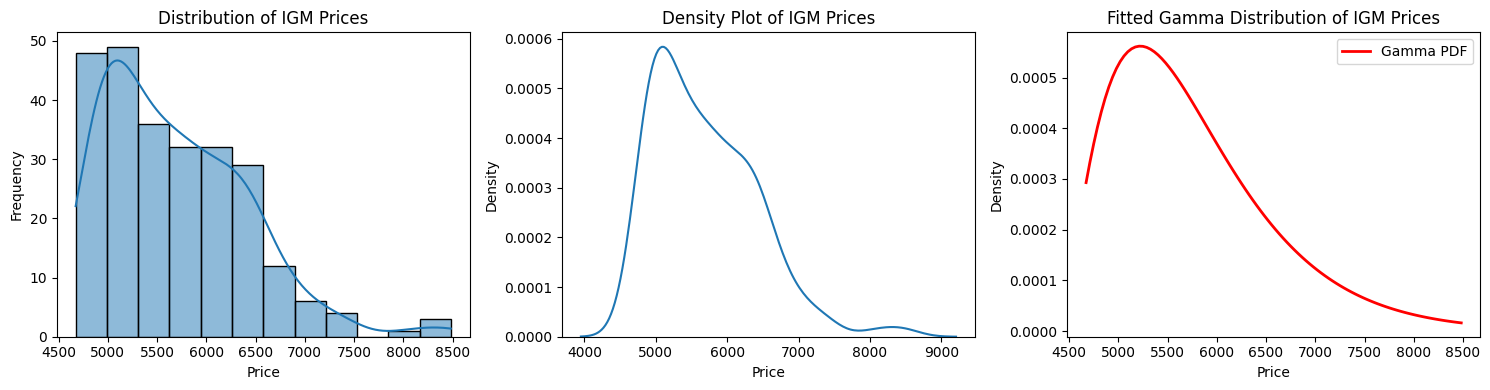

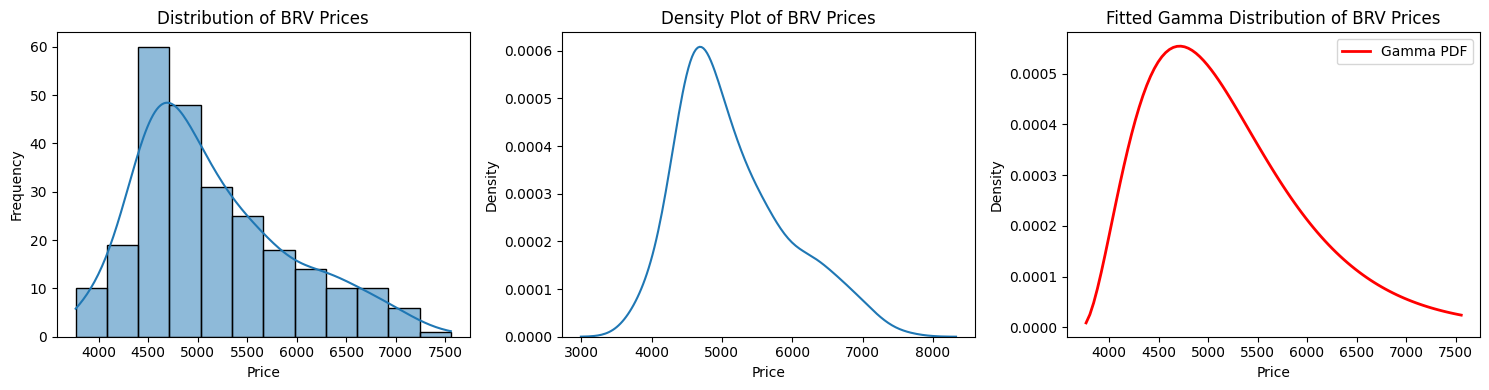

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from prediction import HistPred, GammaKDE, GammaDistribution, GaussianKDE
import numpy as np

# Load the data
data = pd.read_csv("/Users/divy/Desktop/Chicago-Trading-Competition-2024/case_1/Case1_Historical.csv", index_col=0)

# Iterate over columns and plot
for col in data.columns:
    col_data = HistPred(col, data[col])
    
    # Fit the Gamma distribution
    # kde = GaussianKDE(data[col])
    # kde.fit()
    gamma_dist = GammaDistribution(data[col])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # Histogram with KDE
    sns.histplot(data[col], kde=True, ax=ax1)
    ax1.set_title(f"Distribution of {col} Prices")
    ax1.set_xlabel("Price")
    ax1.set_ylabel("Frequency")
    
    # Density plot
    sns.kdeplot(data[col], ax=ax2)
    ax2.set_title(f"Density Plot of {col} Prices")
    ax2.set_xlabel("Price")
    ax2.set_ylabel("Density")
    
    
    # Plot the fitted Gamma distribution
    x = np.linspace(data[col].min(), data[col].max(), 100)
    y = gamma_dist.pdf(x)
    ax3.plot(x, y, 'r-', lw=2, label='Gamma PDF')
    ax3.set_title(f"Fitted Gamma Distribution of {col} Prices")
    ax3.set_xlabel("Price")
    ax3.set_ylabel("Density")
    ax3.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

    # Gamma distribution fit
    # gamma_kde = GammaKDE(data[col])
    # gamma_kde.fit()
    # x_range = np.linspace(data[col].min(), data[col].max(), 100)
    # gamma_pdf = [gamma_kde.pdf(x) for x in x_range]
    # ax3.plot(x_range, gamma_pdf, label='Gamma Distribution')
    # ax3.set_title(f"Gamma Distribution Fit for {col} Prices")
    # ax3.set_xlabel("Price")
    # ax3.set_ylabel("Density")
    # ax3.legend()

    # plt.tight_layout()
    # plt.show()

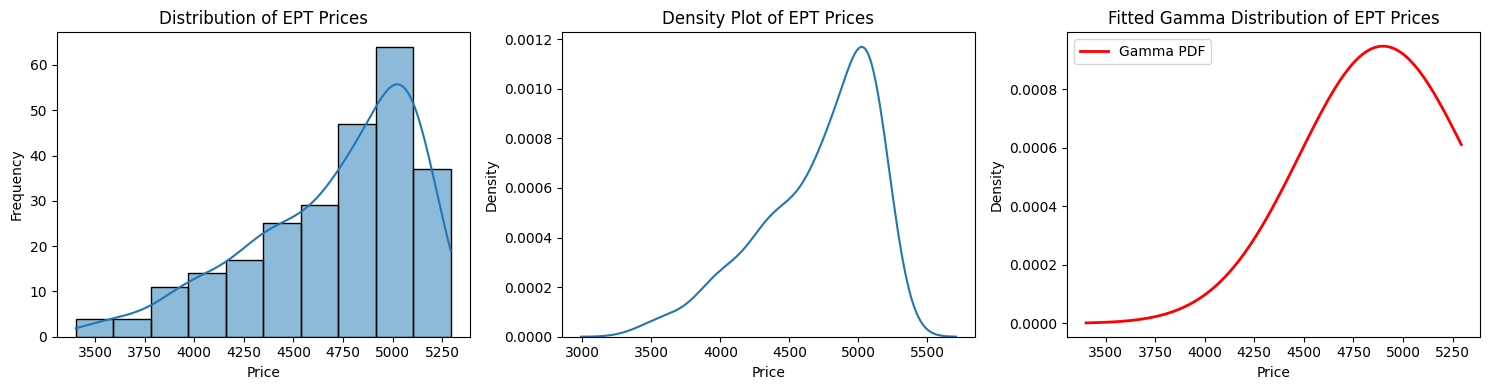

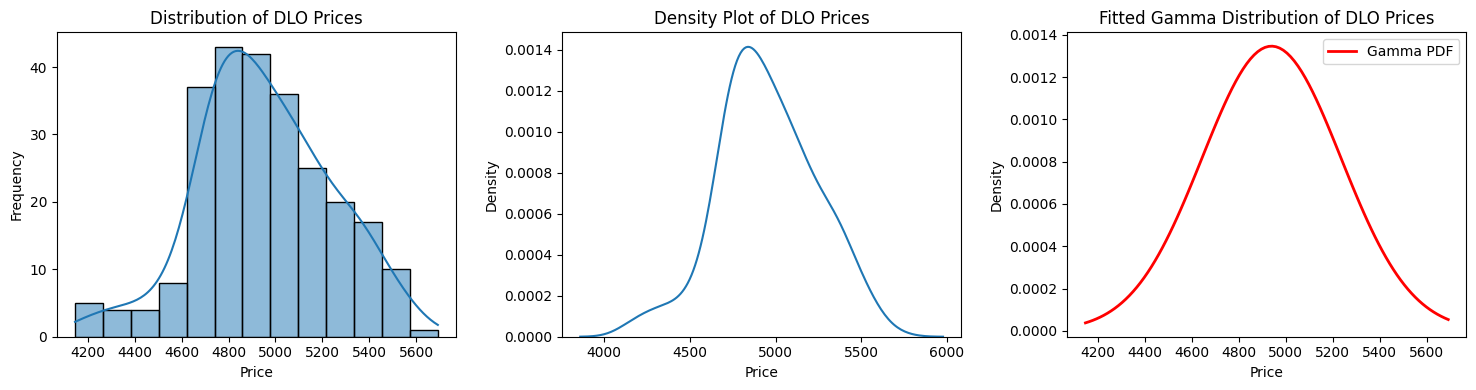

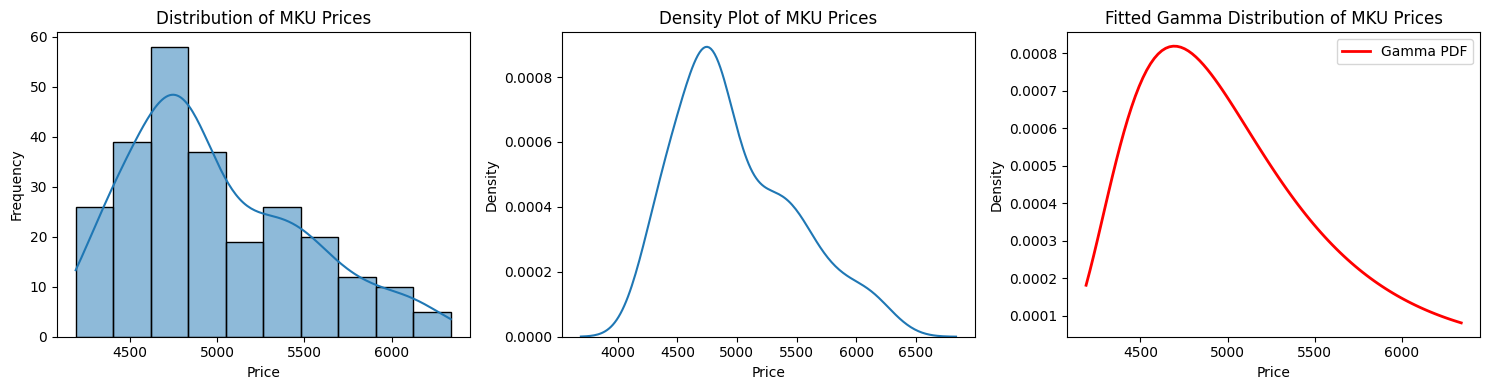

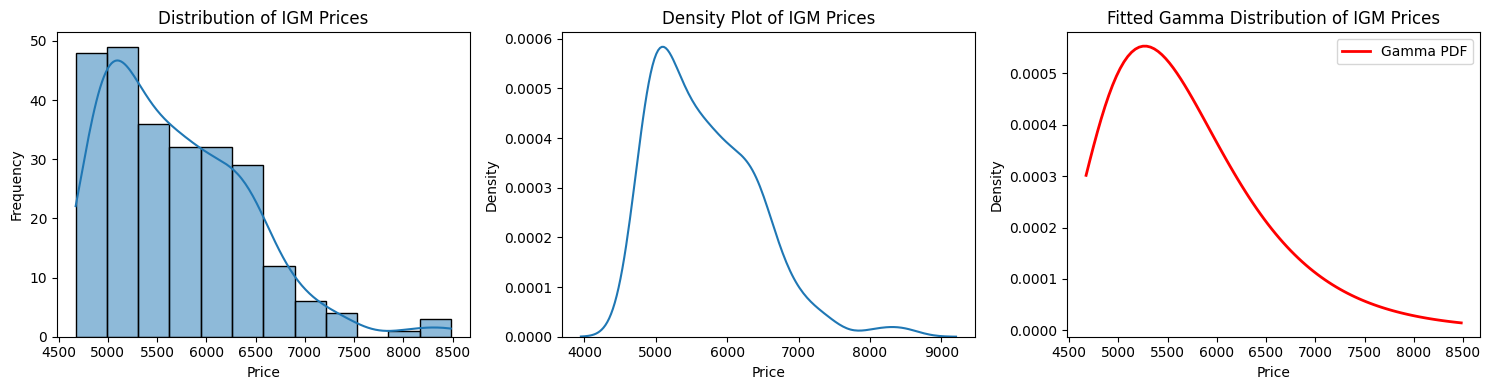

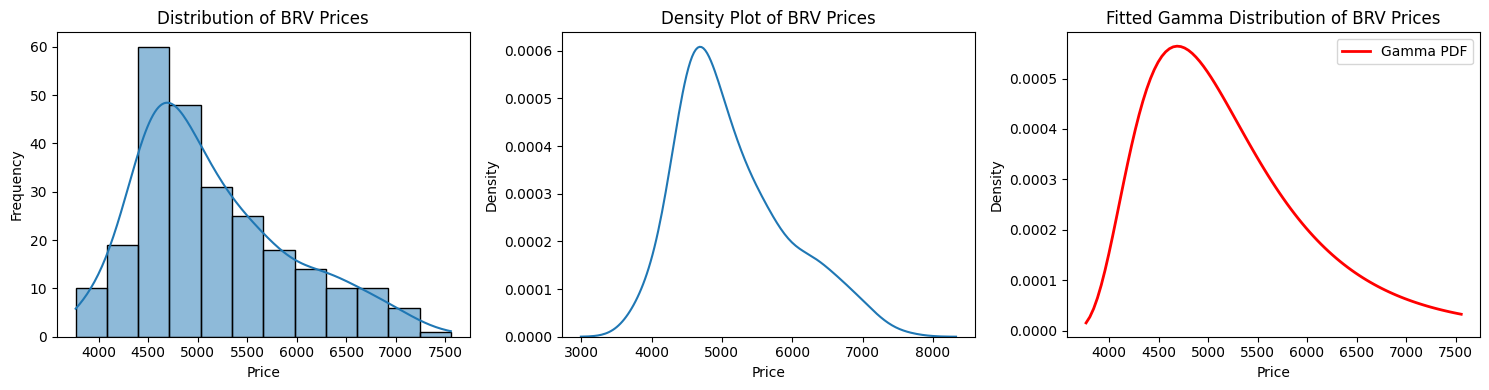

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from prediction import HistPred, GammaKDE, GammaDistribution, GaussianKDE, LognormDistribution
import numpy as np

# Load the data
data = pd.read_csv("/Users/divy/Desktop/Chicago-Trading-Competition-2024/case_1/Case1_Historical.csv", index_col=0)

# Iterate over columns and plot
for col in data.columns:
    col_data = HistPred(col, data[col])
    
    # Fit the Gamma distribution
    # kde = GaussianKDE(data[col])
    # kde.fit()
    gamma_dist = LognormDistribution(data[col])
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    # Histogram with KDE
    sns.histplot(data[col], kde=True, ax=ax1)
    ax1.set_title(f"Distribution of {col} Prices")
    ax1.set_xlabel("Price")
    ax1.set_ylabel("Frequency")
    
    # Density plot
    sns.kdeplot(data[col], ax=ax2)
    ax2.set_title(f"Density Plot of {col} Prices")
    ax2.set_xlabel("Price")
    ax2.set_ylabel("Density")
    
    
    # Plot the fitted Gamma distribution
    x = np.linspace(data[col].min(), data[col].max(), 100)
    y = gamma_dist.pdf(x)
    ax3.plot(x, y, 'r-', lw=2, label='Gamma PDF')
    ax3.set_title(f"Fitted Gamma Distribution of {col} Prices")
    ax3.set_xlabel("Price")
    ax3.set_ylabel("Density")
    ax3.legend(loc='best')
    
    plt.tight_layout()
    plt.show()

    # Gamma distribution fit
    # gamma_kde = GammaKDE(data[col])
    # gamma_kde.fit()
    # x_range = np.linspace(data[col].min(), data[col].max(), 100)
    # gamma_pdf = [gamma_kde.pdf(x) for x in x_range]
    # ax3.plot(x_range, gamma_pdf, label='Gamma Distribution')
    # ax3.set_title(f"Gamma Distribution Fit for {col} Prices")
    # ax3.set_xlabel("Price")
    # ax3.set_ylabel("Density")
    # ax3.legend()

    # plt.tight_layout()
    # plt.show()

Column (Stock): EPT
Best Distribution: norm
Parameters: (4705.341269841269, 415.35371544229724)



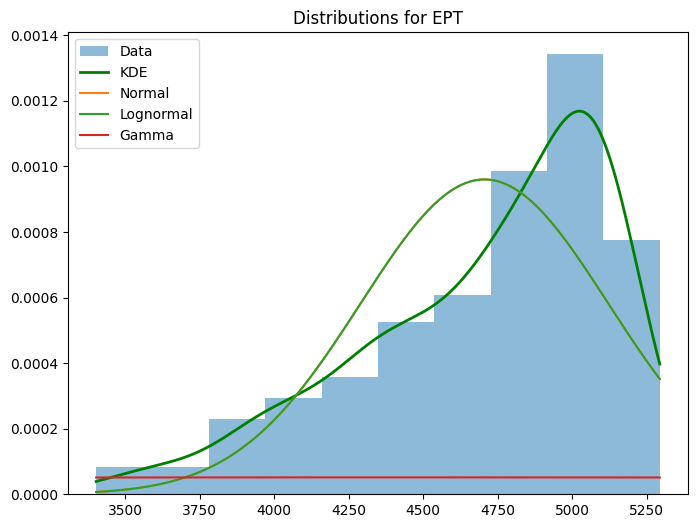

Column (Stock): DLO
Best Distribution: gamma
Parameters: (2467.820249318582, -9329.684149943296, 5.787001127971864)



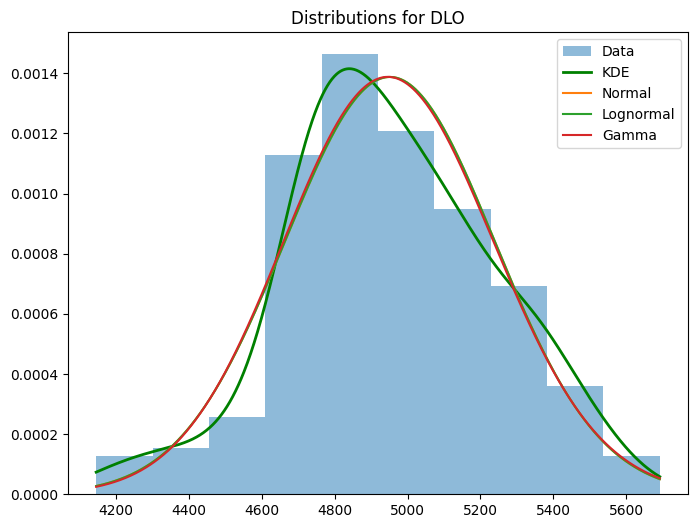

Column (Stock): MKU
Best Distribution: lognorm
Parameters: (0.40270382418182865, 3733.1568842205147, 1158.1320986157264)



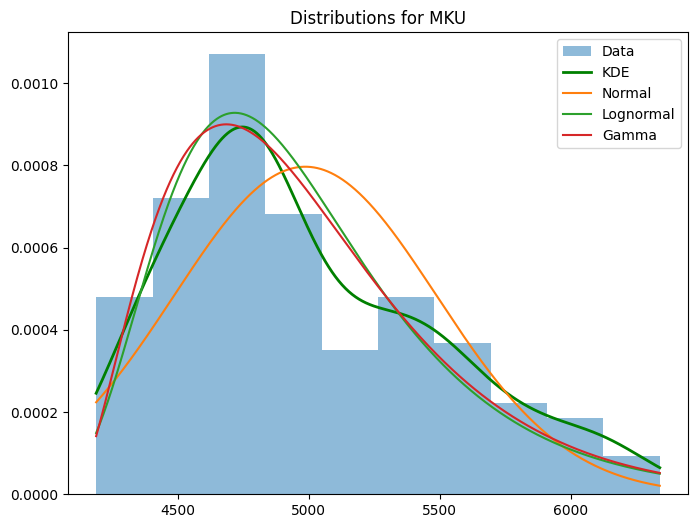

Column (Stock): IGM
Best Distribution: gamma
Parameters: (1.8198271765756484, 4651.015782170742, 571.9888044813761)



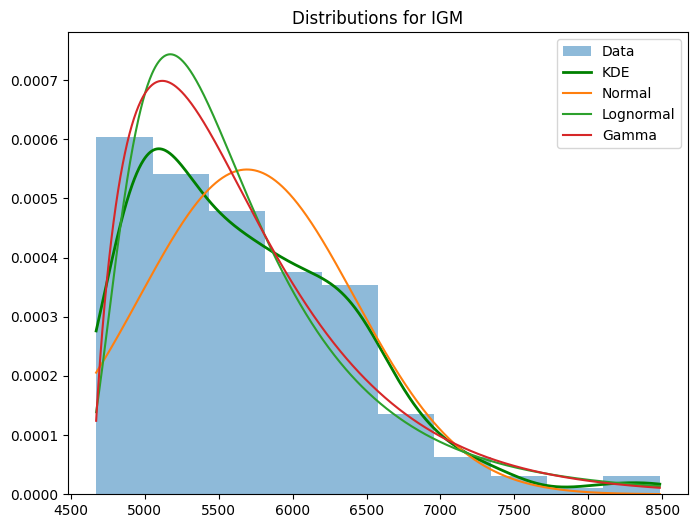

Column (Stock): BRV
Best Distribution: lognorm
Parameters: (0.367875421209485, 3070.363652275146, 1947.4387869918921)



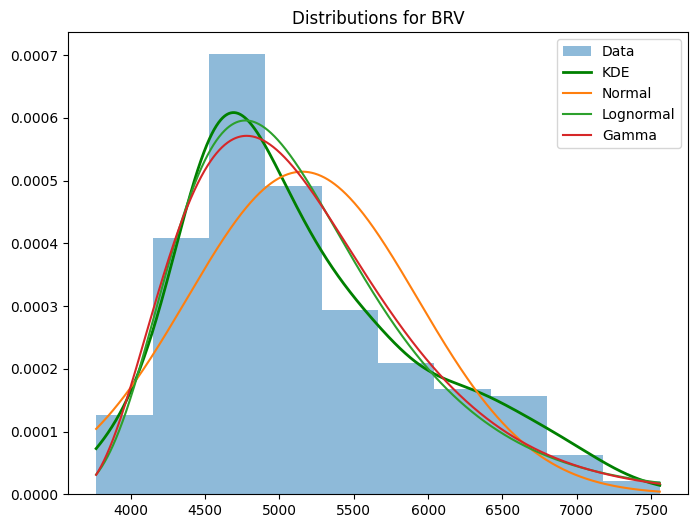

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm, gamma, beta, weibull_min, gaussian_kde

# Load the CSV file
data = pd.read_csv('/Users/divy/Desktop/Chicago-Trading-Competition-2024/case_1/Case1_Historical.csv', index_col=0)

# Define the distributions to test
distributions = [norm, lognorm, gamma, beta, weibull_min]
distribution_names = ['Normal', 'Lognormal', 'Gamma']

# Iterate over each column (stock) in the data
for column in data.columns:
    # Find the best distribution for the column
    best_distribution = None
    best_params = None
    best_sse = np.inf

    for distribution, name in zip(distributions, distribution_names):
        try:
            # Fit the distribution to the data
            params = distribution.fit(data[column])

            # Calculate the sum of squared errors
            sse = np.sum((data[column] - distribution.pdf(data[column], *params)) ** 2)

            # Check if this is the best distribution so far
            if sse < best_sse:
                best_distribution = distribution
                best_params = params
                best_sse = sse
        except Exception:
            # Skip this distribution if it fails to fit the data
            pass

    print(f"Column (Stock): {column}")
    print(f"Best Distribution: {best_distribution.name}")
    print(f"Parameters: {best_params}")
    print()

    # Visualize the data, all distributions, and KDE
    x = np.linspace(data[column].min(), data[column].max(), 1000)
    plt.figure(figsize=(8, 6))
    plt.hist(data[column], bins=10, density=True, alpha=0.5, label='Data')

    # Plot KDE
    kde = gaussian_kde(data[column])
    plt.plot(x, kde(x), 'g-', lw=2, label='KDE')

    for distribution, name in zip(distributions, distribution_names):
        try:
            params = distribution.fit(data[column])
            plt.plot(x, distribution.pdf(x, *params), label=name)
        except Exception:
            # Skip this distribution if it fails to fit the data
            pass

    plt.legend()
    plt.title(f"Distributions for {column}")
    plt.show()

ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.lognorm` documentation for details.

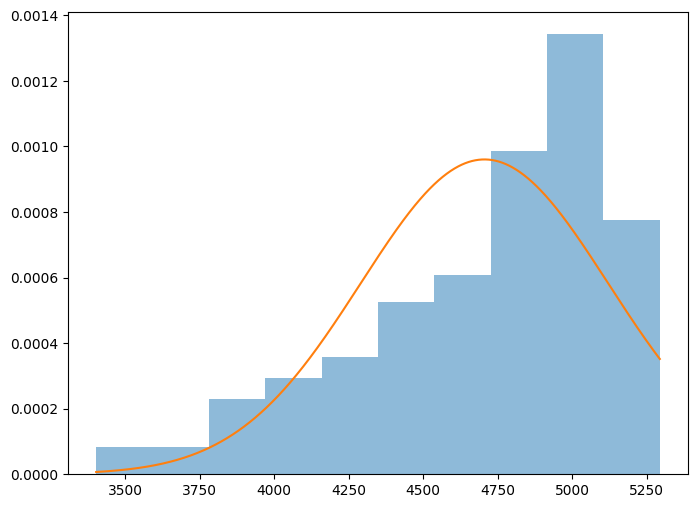

In [39]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import matplotlib.pyplot as plt

# Read the data
data = pd.read_csv('/Users/divy/Desktop/Chicago-Trading-Competition-2024/case_1/Case1_Historical.csv', index_col=0)

# Define the distributions to fit
distributions = [
    stats.norm, stats.lognorm, stats.gamma, stats.beta,
    stats.expon
]

# Iterate over each column in the data
for column in data.columns:
    # Get the column data
    column_data = data[column].dropna()

    # Fit KDE distribution
    kde = stats.gaussian_kde(column_data)

    # Initialize variables to store the best distribution and its parameters
    best_distribution = None
    best_params = None
    best_ks_statistic = np.inf

    # Create a figure for each column
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot the histogram of the data
    ax.hist(column_data, density=True, alpha=0.5, label='Data')

    # Iterate over each distribution
    for distribution in distributions:
        # Define the objective function for minimizing KS statistic
        def objective(params):
            samples = distribution.rvs(*params, size=len(column_data))
            ks_statistic, _ = stats.ks_2samp(column_data, samples)
            return ks_statistic

        # Set custom initial parameters for the gamma distribution
        if distribution == stats.gamma:
            mean = np.mean(column_data)
            variance = np.var(column_data)
            shape = mean**2 / variance
            scale = variance / mean
            params = (shape, 0, scale)  # (shape, loc, scale)
        else:
            params = distribution.fit(column_data)

        # Finetune the distribution parameters using BFGS optimization
        result = optimize.minimize(objective, params, method='BFGS')
        params = result.x
        # Generate random samples from the finetuned distribution
        samples = distribution.rvs(*params, size=len(column_data))

        # Compare the finetuned distribution with the KDE distribution using KS test
        ks_statistic, _ = stats.ks_2samp(column_data, samples)

        # Update the best distribution if the KS statistic is smaller
        if ks_statistic < best_ks_statistic:
            best_distribution = distribution
            best_params = params
            best_ks_statistic = ks_statistic

        # Plot the finetuned distribution
        x = np.linspace(column_data.min(), column_data.max(), 1000)
        ax.plot(x, distribution.pdf(x, *params), label=f'{distribution.name} (KS={ks_statistic:.4f})')

    # Plot the KDE distribution
    x = np.linspace(column_data.min(), column_data.max(), 1000)
    ax.plot(x, kde(x), label='KDE')

    # Set the plot labels and title
    ax.set_xlabel(column)
    ax.set_ylabel('Density')
    ax.set_title(f'Fitted Distributions for {column}')
    ax.legend()

    # Print the best distribution and its parameters
    print(f"Best distribution for {column}: {best_distribution.name}")
    print(f"Best parameters: {best_params}")

    # Show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
analysis = TradingAnalysis('Case1_Historical.csv')
analysis.plot_price_series()
analysis.plot_distributions()
analysis.plot_correlation_matrix()
analysis.augmented_dickey_fuller_test()
analysis.hurst_exponent()
analysis.cointegration_test()
analysis.granger_causality_test()
analysis.predictive_modeling()
analysis.principal_component_analysis()
